# Pregunta 3: Metaheurísticas
Decidimos escoger las metaherísticas de :
* Búsqueda local
* Búsqueda tabú
***

### Algoritmo de Búsqueda local basado en viajes inversos

El algoritmo de **búsqueda local** genérico es como sigue:  
Dada una vecindad $V$ para una solución $s$
1. Construir un recorrido inicial arbitrario $s_0$ y sea $s_i = s_0$.
2. Construir una vecindad de soluciones $V(s_i) - s_i$
3. Elegir  $s_j \in V(s_0) - s_0$ tal que $d(s_j) \leq d(s_e)$ para toda $s_e \in V(s_0) - s_0$ donde $d$ es la función de costo utilizada para la solución. 
4. Si $d(s_j) < d(s_i)$ entonces $s_i=s_j$ y repetir el paso 2.
5. Si no. PARAR, se ha alcanzado la solución.

Faltan dos acpectos por definir en el algoritmo anterior, la estructura de la vecindad y la función de costo.
En este caso la función de costo estará dada por la suma de los costos de recorrer de un nodo a otro que están dados por una matriz de adyacencia.  
La vecindad de una solucion $s_i$ estará dada por el conjunto de todos los **subviajes inversos**. Un subviaje inverso es "una secuencia de ciudades visitadas en la solución de prueba actual mediante la selección de una subsecuencia de las ciudades y simplemente invertir el orden en el cual se visita esa subsecuencia de ciudades" [Hillier y Lieberman, pág. 568](https://dudasytareas.files.wordpress.com/2017/05/hillier_lieberman.pdf)  


Por ejemplo, si se tiene el recorrido de 10 nodos representado por:  

> 1-2-3-4-5-6-7-8-9-10-1 

algunos subviajes inversos de este recorrido son: 

>> 1-3-2-4-5-6-7-8-9-10-1   
>> 1-2-8-7-6-5-4-3-9-10-1  
>> 1-2-3-4-5-6-7-8-10-9-1  

### Algoritmo de Búsqueda Tabú basado en viajes inversos

El algoritmo de **búsqueda Tabú** es muy parecido al de **búsqueda local**, pero en este caso en cada iteración definimos un conjunto de pasos prohíbidos definidos por conidciones almacenadas en la lista tabú. El algoritmo genérico es como sigue:

Dada una vecindad $V$ para una solución $s$, una lista tabu $t$ y un número de fallas máximas consecutivas $sup_t$
1. Construir un recorrido inicial arbitrario $s_0$ con $s_i = s_0$ y $s_{mimimo,hasta,ahora} = s_i$
2. Construir una vecindad de soluciones $V(s_i) - s_i$
3. Elegir  $s_j \in V(s_0) - s_0$ tal que $d(s_j) \leq d(s_e)$ para toda $s_e \in V(s_0) - s_0$  y además que $s_j \notin t$.
4. Si $d(s_{mimimo,hasta,ahora}) < d(s_j)$ entonces $s_{mimimo,hasta,ahora} = s_j$ y resetear el número de fallos a $0$.
5. De cualquier modo $s_i=s_j$, pero si $d(s_j) \nless d(s_i)$ aumentar el número de fallos en 1.
6. Si el número de fallos es igual o excede a $sup_t$. PARAR, y considerar como solución a $s_{mimimo,hasta,ahora}$.  


Hay varios puntos a considerar en el algoritmo. Para simplificar el proceso seguimos los parámetros que nos sugieren [Hillier y Lieberman, pág. 578](https://dudasytareas.files.wordpress.com/2017/05/hillier_lieberman.pdf) los cuales son:  


1. Algoritmo de búsqueda local: En cada iteración seleccione el mejor vecino inmediato de la solución de prueba actual que no esté descartado por la lista tabú.
2. Estructura de vecindad: Un vecino inmediato de la solución de prueba actual es aquel al que se llega por medio de un subviaje inverso. Tal inversión requiere la adición de dos ligaduras y la eliminación de otras dos ligaduras de la solución de prueba actual. (Se descarta un subviaje inverso que sólo invierta la dirección del viaje que proporciona la solución de prueba actual.)
3. Forma de los movimientos tabú: Enumere las ligaduras de forma que un subviaje inverso sea tabú si las dos ligaduras que se eliminan por esta inversión se encuentran en la lista. (Ello evitará que se regrese con rapidez a la solución de prueba anterior.)
4. Adición de un movimiento tabú: En cada iteración, después de elegir las dos ligaduras que deben agregarse a la solución de prueba actual, también incorpore estas dos ligaduras a la lista tabú.
5. Tamaño máximo de la lista tabú: el multiplo de cuatro más cercano a $n/4$ donde $n$ es el número de nodos del problema. Siempre que se agregue un par de ligaduras a una lista llena, elimine las dos ligaduras que han permanecido por más tiempo en la lista.
6. Regla de detención: Detenga el proceso después de tres iteraciones consecutivas sin mejora del mejor valor de la función objetivo. (También debe detenerse en cualquier iteración donde la solución de prueba actual no tenga vecinos inmediatos que no estén descartados por la lista tabú.)

In [1]:
# importamos las librerias necesarias
from collections import namedtuple
import pandas as pd
import os
import time
from math import sqrt
import random

#importamos liberias de grafiacion
import matplotlib.pyplot as plt

# importmos los componentes y algoritmos que programamos
from graphComponents import GraphTSP
from metaheuristics import tsp_local_search, tsp_tabu_search


In [2]:
def plot_graph_path(ax, graph, name, path=True):
    def plot_path(path):
        keys, x, y = [], [], []
        for node in path:
            keys.append(node.key)
            x.append(node.x)
            y.append(node.y)
        return keys, x, y
    
    keys, x, y = plot_path(graph.current_path)
    ax.scatter(x, y)
    if path:
        ax.plot(x + [x[0]], y + [y[0]])
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    for i, txt in enumerate(keys):
        ax.annotate(txt, (x[i], y[i]),
            textcoords="offset points",
            xytext=(0,10), fontsize=12)
    ax.set_title(name, fontsize=17)
        
def plot_two_results(graph1, graph2, instance):
    fig, axes = plt.subplots(1,3, figsize=(17,8))
    fig.suptitle(f"Instancia: {instance}", fontsize=20)
    plot_graph_path(axes[0], graph1, "Ciudades", False)
    plot_graph_path(axes[1], graph1, "Búsqueda local")
    plot_graph_path(axes[2], graph2, "Búsqueda tabú")
    plt.show()
        
def plot_graph(graph, name):
    def plot_path(path):
        keys, x, y = [], [], []
        for node in path:
            keys.append(node.key)
            x.append(node.x)
            y.append(node.y)
        return keys, x, y
    
    fig, axes = plt.subplots(1,2, figsize=(17,8))
    fig.suptitle(name, fontsize=16)
    keys, x, y = plot_path(graph.initial_path)
    axes[0].scatter(x, y)
    #axes[0].plot(x + [x[0]], y + [y[0]])
    axes[0].grid(b=True, which='major', color='#666666', linestyle='-')
    axes[0].minorticks_on()
    axes[0].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[0].set_xlabel('x', fontsize=15)
    axes[0].set_ylabel('y', fontsize=15)
    for i, txt in enumerate(keys):
        axes[0].annotate(txt, (x[i], y[i]),
            textcoords="offset points",
            xytext=(0,10), fontsize=15)
        axes[0].set_title("Inicial", fontsize=20)

    keys, x, y = plot_path(graph.current_path)
    axes[1].scatter(x, y)
    axes[1].plot(x + [x[0]], y + [y[0]])
    axes[1].grid(b=True, which='major', color='#666666', linestyle='-')
    axes[1].minorticks_on()
    axes[1].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[1].set_xlabel('x', fontsize=15)
    axes[1].set_ylabel('y', fontsize=15)
    for i, txt in enumerate(keys):
        axes[1].annotate(txt, (x[i], y[i]),
            textcoords="offset points",
            xytext=(0,10), fontsize=15)
        axes[1].set_title("Final", fontsize=20)
    plt.show()

### Parte 1
Calculamos la distancia mínima para cada una de las instancias con 29, 48, 51, 21 y 70 nodos respectivamente utilizando las metaherísticas.

archivo: bayg29.txt
Recorrido inicial:
14-8-12-15-3-1-24-28-5-29-13-27-21-26-4-22-7-25-19-2-17-16-6-18-23-9-20-11-10-14
Recorrido final local search:
20-2-21-29-3-26-5-9-12-6-28-1-24-16-27-8-23-7-25-19-11-22-17-14-18-15-4-13-10-20
Recorrido inicial:
14-8-12-15-3-1-24-28-5-29-13-27-21-26-4-22-7-25-19-2-17-16-6-18-23-9-20-11-10-14
Recorrido final tabú search:
20-2-21-5-29-3-26-9-12-6-28-1-24-16-27-8-23-7-25-19-11-22-17-14-18-15-4-13-10-20


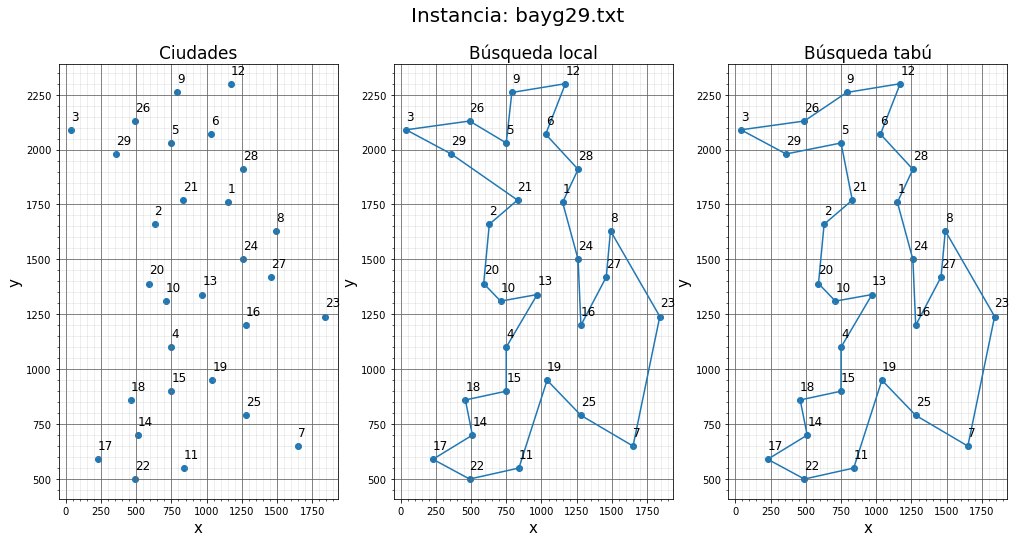


archivo: att48.txt
Recorrido inicial:
15-43-35-6-30-14-20-48-11-23-22-4-10-37-18-32-19-31-38-36-33-41-25-28-9-8-26-46-2-3-24-34-13-17-12-42-7-44-39-21-29-47-40-1-16-5-27-45-15
Recorrido final local search:
10-24-5-48-39-32-21-13-25-14-23-11-47-20-33-12-40-15-46-36-30-43-17-27-19-37-6-28-7-18-44-31-38-9-8-1-16-22-3-34-41-29-2-42-26-4-35-45-10
Recorrido inicial:
1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-1
Recorrido final tabú search:
39-32-21-47-13-25-14-23-11-12-20-33-15-46-36-30-43-17-27-19-37-6-28-7-18-44-31-38-8-1-9-40-3-22-16-41-34-29-2-26-4-35-45-10-24-42-5-48-39


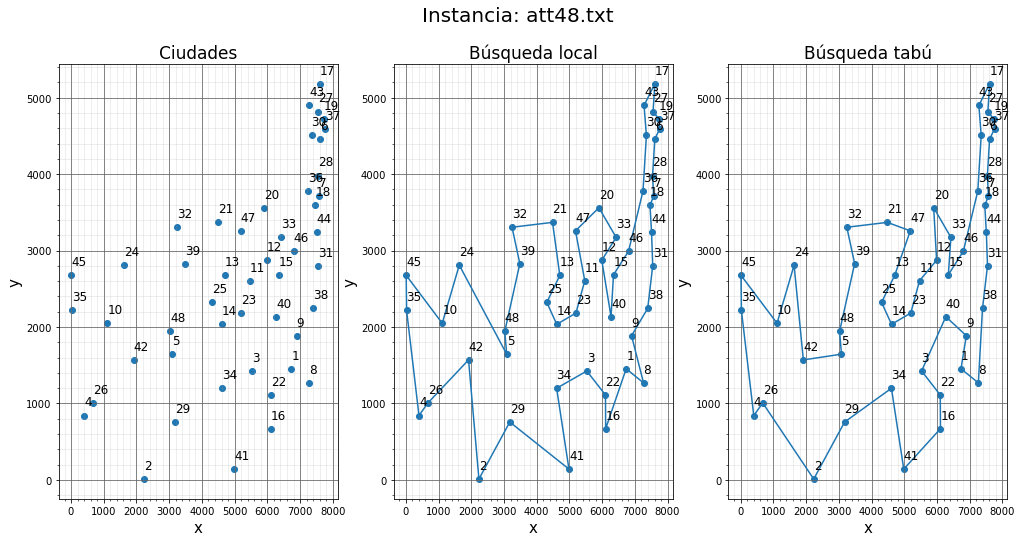


archivo: eil51.txt
Recorrido inicial:
41-2-21-31-37-48-24-20-40-39-6-4-14-25-13-36-16-47-42-10-35-18-11-34-43-26-32-17-46-30-23-3-15-28-49-12-27-51-5-19-1-29-33-9-38-8-44-22-50-45-7-41
Recorrido final local search:
26-8-31-28-22-1-32-11-38-5-49-9-50-16-2-20-3-36-35-29-21-34-30-10-39-33-45-15-44-37-17-42-19-40-41-13-25-14-18-4-47-12-46-51-27-6-48-23-24-43-7-26
Recorrido inicial:
41-2-21-31-37-48-24-20-40-39-6-4-14-25-13-36-16-47-42-10-35-18-11-34-43-26-32-17-46-30-23-3-15-28-49-12-27-51-5-19-1-29-33-9-38-8-44-22-50-45-7-41
Recorrido final tabú search:
26-8-31-28-22-1-32-11-38-5-49-9-50-16-2-3-36-35-20-29-21-34-30-10-39-33-45-15-37-17-44-42-19-40-41-13-25-14-18-4-47-12-46-51-27-6-48-23-24-43-7-26


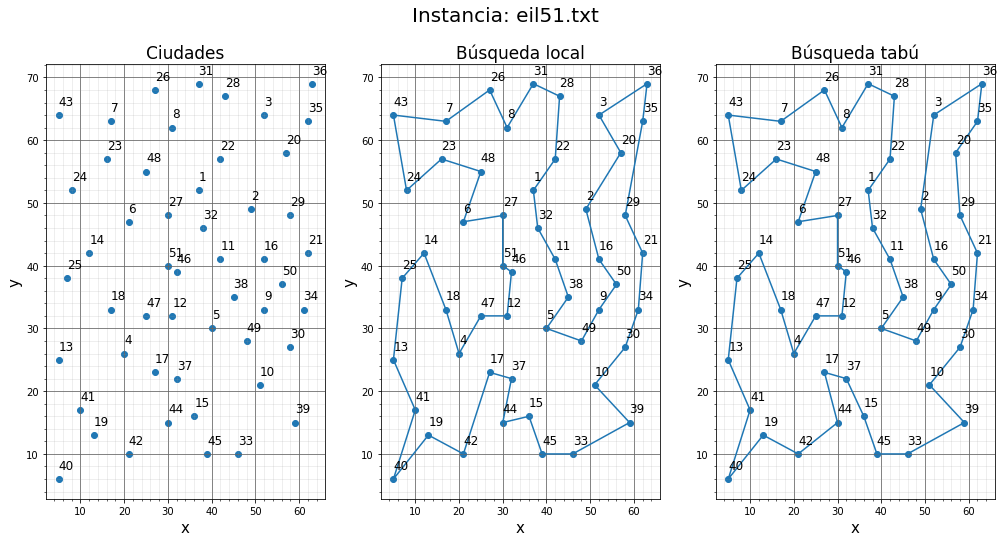


archivo: berlin52.txt
Recorrido inicial:
40-36-27-7-8-44-49-43-26-41-51-34-6-14-19-2-21-47-10-46-18-4-52-37-33-20-12-5-42-29-16-15-45-31-32-24-30-13-28-3-17-11-25-1-39-22-35-9-38-50-48-23-40
Recorrido final local search:
31-18-21-42-2-7-17-3-45-19-41-8-9-10-43-33-51-11-52-14-13-47-26-27-28-12-25-4-6-15-5-24-48-46-37-38-40-39-34-35-36-49-32-22-1-44-16-29-50-20-30-23-31
Recorrido inicial:
40-36-27-7-8-44-49-43-26-41-51-34-6-14-19-2-21-47-10-46-18-4-52-37-33-20-12-5-42-29-16-15-45-31-32-24-30-13-28-3-17-11-25-1-39-22-35-9-38-50-48-23-40
Recorrido final tabú search:
31-18-21-42-2-7-17-3-45-19-41-8-9-10-43-33-51-11-52-14-13-47-26-27-28-12-25-4-6-15-5-24-48-46-37-38-40-39-34-35-36-49-32-22-1-44-16-29-50-20-30-23-31


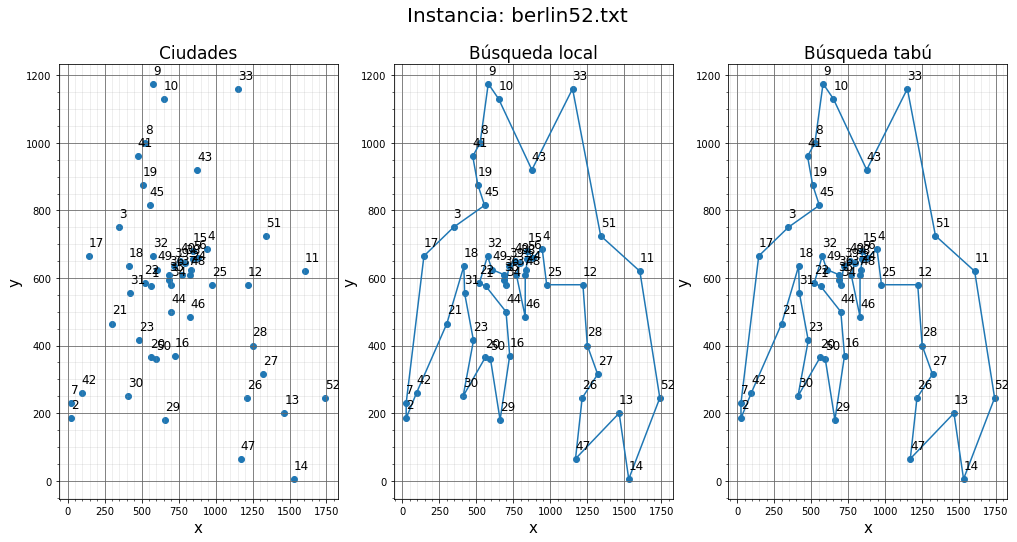


archivo: st70.txt
Recorrido inicial:
25-42-6-51-11-53-14-9-63-70-41-56-13-26-64-35-47-44-30-18-66-61-55-36-23-59-39-15-48-8-27-2-43-21-37-69-32-67-20-16-62-33-1-60-54-50-52-58-40-49-24-12-65-46-4-38-10-19-31-34-3-57-28-7-45-68-5-22-17-29-25
Recorrido final local search:
13-31-69-38-23-36-1-16-47-37-58-50-53-5-10-52-60-51-56-65-64-11-67-48-54-62-33-12-34-21-17-43-9-40-61-39-25-45-46-27-68-44-30-20-14-28-49-55-26-8-3-32-42-41-6-18-4-2-7-19-24-15-57-63-66-22-59-35-70-29-13
Recorrido inicial:
25-42-6-51-11-53-14-9-63-70-41-56-13-26-64-35-47-44-30-18-66-61-55-36-23-59-39-15-48-8-27-2-43-21-37-69-32-67-20-16-62-33-1-60-54-50-52-58-40-49-24-12-65-46-4-38-10-19-31-34-3-57-28-7-45-68-5-22-17-29-25
Recorrido final tabú search:
13-31-69-38-23-36-1-16-47-37-58-50-53-5-10-52-60-51-56-65-64-11-67-48-54-62-33-12-34-21-17-43-9-40-61-39-25-45-46-27-68-44-30-20-14-28-49-55-26-8-3-32-42-41-6-18-4-2-7-19-24-15-57-63-66-22-59-35-70-29-13


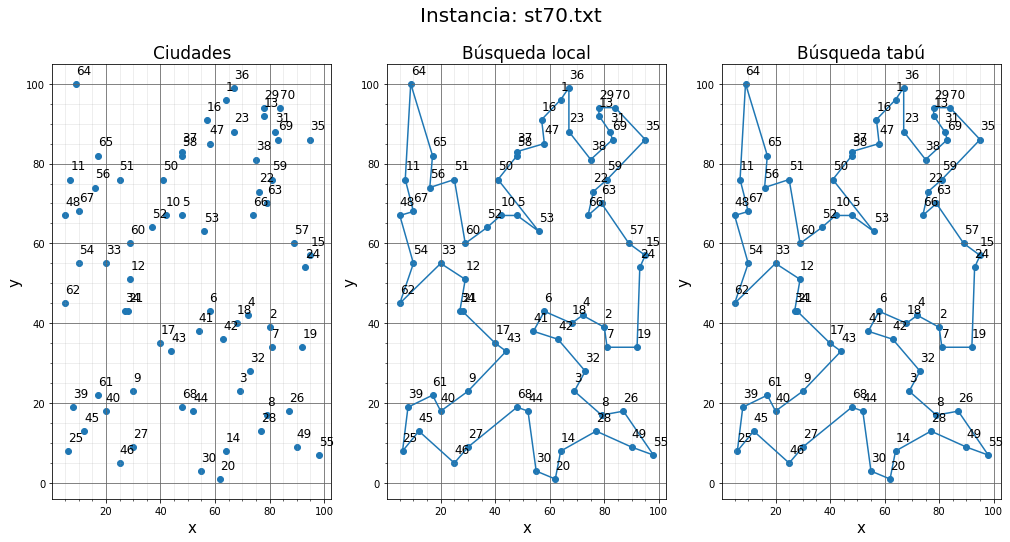

,Archivo,Nodos,Longitud inicial,Longitud final búsqueda local,Longitud final búsqueda tabú,Tiempo de ejecución búsqueda local,Tiempo de ejecución búsqueda tabú,Iteraciones búsqueda local,Iteraciones búsqueda tabú
0,bayg29.txt,29,25371.35,9111.61,9076.98,0.3159,0.5683,25,36
1,att48.txt,48,159309.16,34482.12,33804.24,2.5549,4.0686,44,69
2,eil51.txt,51,1734.59,438.32,433.73,3.0797,4.8058,48,73
3,berlin52.txt,52,31367.70,7918.74,7918.74,3.1152,4.7683,41,59
4,st70.txt,70,3762.88,684.09,684.09,11.8844,16.5018,64,92


In [8]:
random.seed('123')

# Diccionario con listas vacias para guardar los resultados finales
resultados = {"Archivo":[],
              "Nodos":[],
              "Longitud inicial":[],
              "Longitud final búsqueda local":[],
              "Longitud final búsqueda tabú":[],
              "Tiempo de ejecución búsqueda local":[],
              "Tiempo de ejecución búsqueda tabú":[],
              "Iteraciones búsqueda local": [],
              "Iteraciones búsqueda tabú": []}

# Número de simulaciones adicionales al camino por default (más de 50 son demasiadas)
simulations = 2

# método auxiliar para calcular distancias entre nodos
def distance_between(Node1, Node2):
        distance = sqrt((Node1.x - Node2.x)**2 + (Node1.y - Node2.y)**2)
        return distance

# lectura de archivos
files = os.listdir("instancias/")
files = sorted(files, key=lambda x: x.split(".")[0][-2:])

# Creación y análisis de grafo por cada archivo
for file in files:
    file_name = "instancias/" + file
    with open(file_name, 'r') as md:
                info_nodes = md.readlines()[6:-1]

    # depuración y almacenamiento de información por cada linea de archivo
    Node_tuple = namedtuple('Node', ['key', 'x', 'y'])
    list_path = []
    for node in info_nodes[:]:
        key, x, y = node.split()
        new_node  = Node_tuple(int(key), float(x), float(y))
        list_path.append(new_node)
        
    
    # creción de la matriz de adyacencia
    adyacent_matrix = [[0 for _ in range(len(list_path))] for _ in range(len(list_path))]
    for start in range(len(list_path)):
        for end in range(len(list_path)):
            if start == end:
                distance = 0
            else:
                distance = distance_between(list_path[start], list_path[end])
            adyacent_matrix[start][end] = distance
            
    test_paths = [list_path]
    for _ in range(simulations):
        initial_path = list_path[:]
        random.shuffle(initial_path)
        test_paths.append(initial_path)
    
    # bucamos el recorrido mínimo usando "busqueda local"
    start_time = time.time()
    min_graph_loc = GraphTSP(test_paths[0], adyacent_matrix)
    for initial_path in test_paths:
        current_graph_loc = GraphTSP(initial_path, adyacent_matrix)
        current_graph_loc, _, i_loc = tsp_local_search(current_graph_loc)################################
        if current_graph_loc.current_path_length < min_graph_loc.current_path_length:
            min_graph_loc = current_graph_loc
    end_time = time.time()
    total_time_loc = round(end_time - start_time,4)
    
    print("archivo:", file) # Nombre de archivo
    print("Recorrido inicial:")
    print(min_graph_loc.print_path()) # Mostramos el camino original
    print("Recorrido final local search:")
    print(min_graph_loc) # Mostamos el camino resultado
    initial_length_loc =  round(min_graph_loc.initial_path_length,2)
    final_length_loc = round(min_graph_loc.current_path_length,2)

    
    # bucamos el recorrido mínimo usando "busqueda Tabú"
    start_time = time.time()
    min_graph_tab = GraphTSP(test_paths[0], adyacent_matrix)
    for initial_path in test_paths:
        current_graph_tab = GraphTSP(initial_path, adyacent_matrix)
        current_graph_tab, i_tab = tsp_tabu_search(current_graph_tab, max_failures=10, 
                                                   max_tabu_elements=current_graph_tab.node_count//2\
                                                               + (4 - (current_graph_tab.node_count // 4) % 4))
        if current_graph_tab.current_path_length < min_graph_tab.current_path_length:
            min_graph_tab = current_graph_tab
    end_time = time.time()
    total_time_tab = round(end_time - start_time,4)
    
    print("Recorrido inicial:")
    print(min_graph_tab.print_path())
    print("Recorrido final tabú search:")
    print(min_graph_tab) # Mostamos el camino resultado
    initial_length_tab =  round(min_graph_tab.initial_path_length,2)
    final_length_tab = round(min_graph_tab.current_path_length,2)
    plot_two_results(min_graph_loc, min_graph_tab, file)
    print()
    
    # Guardamos los datos para mostrarlos en una tabla
    resultados["Archivo"].append(file)
    resultados["Nodos"].append(min_graph_loc.node_count)
    resultados["Longitud inicial"].append(initial_length_loc)
    resultados["Longitud final búsqueda local"].append(final_length_loc)
    resultados["Longitud final búsqueda tabú"].append(final_length_tab)
    resultados["Tiempo de ejecución búsqueda local"].append(total_time_loc)
    resultados["Tiempo de ejecución búsqueda tabú"].append(total_time_tab)
    resultados["Iteraciones búsqueda local"].append(i_loc)
    resultados["Iteraciones búsqueda tabú"].append(i_tab)

results = pd.DataFrame(resultados)
results

### Parte2: Cosméticos *Mac Bella*

In [36]:
# Diccionario con listas vacias para guardar los resultados finales
resultados = {"Nodos":[],
              "Longitud inicial":[],
              "Longitud final búsqueda local":[],
              "Longitud final búsqueda tabú":[],
              "Tiempo de ejecución búsqueda local":[],
              "Tiempo de ejecución búsqueda tabú":[],
              "Iteraciones búsqueda local": [],
              "Iteraciones búsqueda tabú": []}

# Creamos la matriz de adyacencia
adyacent_matrix = [[0, 2, 2, 3, 4, 5, 4, 3, 5, 6],
                   [2, 0, 1, 3, 3, 4, 6, 4, 3, 5],
                   [2, 1, 0, 4, 5, 3, 2, 4, 1, 7],
                   [3, 3, 4, 0, 2, 4, 5, 3, 5, 2],
                   [4, 3, 5, 2, 0, 2, 4, 1, 2, 2],
                   [5, 4, 3, 4, 2, 0, 3, 2, 1, 3],
                   [4, 6, 2, 5, 4, 3, 0, 3, 2, 1],
                   [3, 4, 4, 3, 1, 2, 3, 0, 5, 3],
                   [5, 3, 1, 5, 2, 1, 2, 5, 0, 4],
                   [6, 5, 7, 2, 2, 3, 1, 3, 4, 0]]

# Creamos los nodos del grafo
Node_mac_bella = namedtuple('Node', ['key'])
list_path = []
for i in range(10):
    new_node = Node_mac_bella(i + 1)
    list_path.append(new_node)
    
# factor constante (tiempo de producción por producto)
constant_cost = sum([60, 31, 45, 60, 71, 82, 52, 44, 74, 100])
    
# declaración del grafo con camino de defecto (1 - 2 - 3 - 4 - 5 - ... - (n-1) - 1)
graph29 = GraphTSP(list_path, adyacent_matrix)
    
# bucamos el recorrido mínimo usando "busqueda local"
start_time = time.time()
graph, reverts, i_loc = tsp_local_search(graph29)########################################
graph_loc = graph
end_time = time.time()
total_time_loc = round(end_time - start_time,5)
print("Recorrido inicial:")
print(graph.print_path()) # Mostramos el camino original
print("Recorrido final local search:")
print(graph) # Mostamos el camino resultado
initial_length =  round(graph.initial_path_length,2) + constant_cost
final_length_loc = round(graph.current_path_length,2) + constant_cost
print(f"Lonigtud original: {initial_length}, longitud resultante: {final_length_loc}, execution time:{total_time_loc}, iteraciones: {i_loc}")

# bucamos el recorrido mínimo usando "busqueda Tabú"
start_time = time.time()
graph, i_tab = tsp_tabu_search(graph29)##########################################
end_time = time.time()
total_time_tab = round(end_time - start_time,4)
print("Recorrido final Tabú search:")
print(graph) # Mostamos el camino resultado
initial_length_tab =  round(graph.initial_path_length,2) + constant_cost
final_length_tab = round(graph.current_path_length,2) + constant_cost
print(f"lonigtud original: {initial_length}, longitud resultante: {final_length_tab}, execution time:{total_time_tab}, iteraciones: {i_tab}")
print()

# Guardamos los datos para mostrarlos en una tabla
resultados["Nodos"].append(graph.node_count)
resultados["Longitud inicial"].append(initial_length)
resultados["Longitud final búsqueda local"].append(final_length_loc)
resultados["Longitud final búsqueda tabú"].append(final_length_tab)
resultados["Tiempo de ejecución búsqueda local"].append(total_time_loc)
resultados["Tiempo de ejecución búsqueda tabú"].append(total_time_tab)
resultados["Iteraciones búsqueda local"].append(i_loc)
resultados["Iteraciones búsqueda tabú"].append(i_tab)

results = pd.DataFrame(resultados)
results

Recorrido inicial:
1-2-3-4-5-6-7-8-9-10-1
Recorrido final local search:
7-6-9-3-2-1-8-5-4-10-7
Lonigtud original: 651, longitud resultante: 636, execution time:0.00135, iteraciones: 4
Recorrido final Tabú search:
7-6-9-3-2-1-8-5-4-10-7
lonigtud original: 651, longitud resultante: 636, execution time:0.0032, iteraciones: 13



,Nodos,Longitud inicial,Longitud final búsqueda local,Longitud final búsqueda tabú,Tiempo de ejecución búsqueda local,Tiempo de ejecución búsqueda tabú,Iteraciones búsqueda local,Iteraciones búsqueda tabú
0,10,651,636,636,0.00135,0.0032,4,13


In [4]:
reverts

[(0, 6), (4, 7), (2, 8), (7, 8)]

In [5]:
print(graph29.print_path())
# 1-2-3-4-5-6-7-8-9-10-1

1-2-3-4-5-6-7-8-9-10-1


In [4]:
def check_reversals(graph, reversals):
    aux_path = graph.initial_path
    for reversal in reversals:
        start = reversal[0]
        end = reversal[1] + 1
        aux_path = graph.invert_path(start, end, aux_path)
        print(graph.print_path(aux_path))
    return graph.current_path == aux_path

print(graph29.print_path())
check_reversals(graph29, reverts)

1-2-3-4-5-6-7-8-9-10-1
7-6-5-4-3-2-1-8-9-10-7
7-6-5-4-8-1-2-3-9-10-7
7-6-9-3-2-1-8-4-5-10-7
7-6-9-3-2-1-8-5-4-10-7


True

In [10]:
print(graph_loc.print_path(graph_loc.current_path))
cum_sum = 0
for pos in range(graph_loc.node_count):
    arc_length = graph_loc.get_cost_of_arc(pos)
    print(f"start: {graph_loc.current_path[(pos + 1)%graph_loc.node_count].key}, end: {}, cost: {constant_cost + graph_loc.current_path_length - arc_length}")

7-6-9-3-2-1-8-5-4-10-7
start: 6, cost: 633
start: 9, cost: 635
start: 3, cost: 635
start: 2, cost: 635
start: 1, cost: 634
start: 8, cost: 633
start: 5, cost: 635
start: 4, cost: 634
start: 10, cost: 634
start: 7, cost: 635
